In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [35]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [44]:
classes=dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 0 0 1 1 0 2 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 2 0 0 0 0 0 1 0]


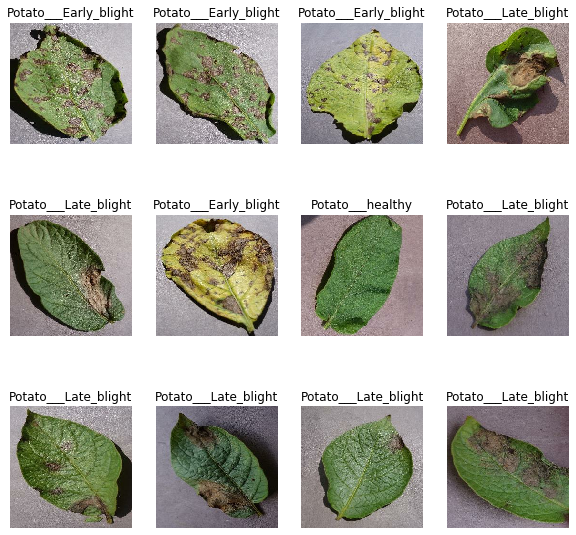

In [48]:
plt.figure(figsize=(10,10))
for image_batch , labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classes[labels_batch[i]])
        plt.axis("off")

In [52]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [53]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [56]:
len(train_ds)

54

In [57]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [60]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [61]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [68]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])
model.build(input_shape=input_shape)

In [69]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 60, 60, 64)         

In [71]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])


In [72]:
history=model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds, verbose=1,epochs=EPOCHS)

Epoch 1/50
54/54 [==============================] - 118s 2s/step - loss: 0.9266 - accuracy: 0.4803 - val_loss: 0.8251 - val_accuracy: 0.5885
Epoch 2/50
54/54 [==============================] - 124s 2s/step - loss: 0.8304 - accuracy: 0.6117 - val_loss: 0.7673 - val_accuracy: 0.6458
Epoch 3/50
54/54 [==============================] - 102s 2s/step - loss: 0.5141 - accuracy: 0.7934 - val_loss: 0.4140 - val_accuracy: 0.8229
Epoch 4/50
54/54 [==============================] - 98s 2s/step - loss: 0.4143 - accuracy: 0.8351 - val_loss: 0.4004 - val_accuracy: 0.8125
Epoch 5/50
54/54 [==============================] - 102s 2s/step - loss: 0.3814 - accuracy: 0.8391 - val_loss: 0.3145 - val_accuracy: 0.8698
Epoch 6/50
54/54 [==============================] - 99s 2s/step - loss: 0.3146 - accuracy: 0.8791 - val_loss: 0.2726 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 100s 2s/step - loss: 0.2833 - accuracy: 0.8837 - val_loss: 0.1997 - val_accuracy: 0.9427
Epoch 8/50
54/5

In [73]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 7s 364ms/step - loss: 0.0152 - accuracy: 1.0000


In [75]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

actual label: Potato___Late_blight
predicted label: Potato___Late_blight


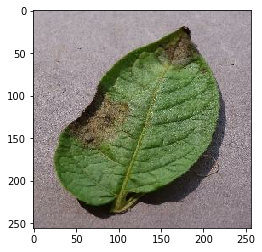

In [87]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_img=images_batch[0].numpy().astype("uint8")
    plt.imshow(first_img)
    print("actual label:", classes[labels_batch[0]])
    batch_prediction=model.predict(images_batch)
    print("predicted label:",classes[np.argmax(batch_prediction[0])])

In [95]:
def predict(model,img):
    img_arr=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr=tf.expand_dims(img_arr,0)
    
    predictions=model.predict(img_arr)
    predicted_class=classes[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class , confidence

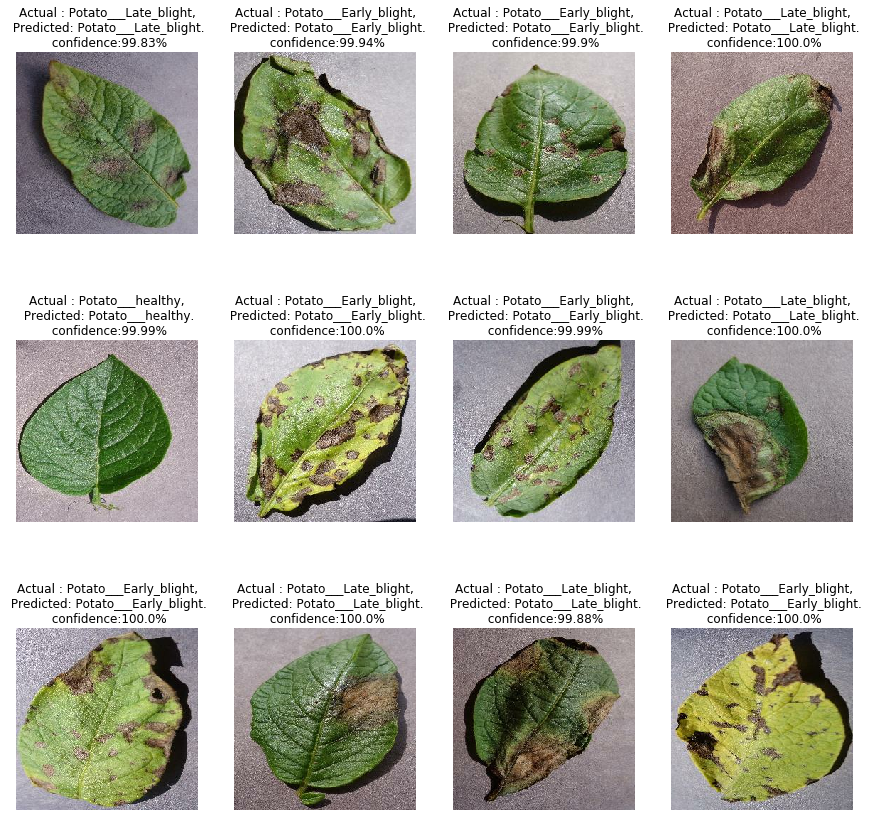

In [96]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        
        actual_class=classes[labels[i]]
        plt.title(f"Actual : {actual_class},\n Predicted: {predicted_class }.\n confidence:{confidence}%")
        plt.axis("off")

In [91]:
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


In [1]:
model.save("potato_disease.h5")

NameError: name 'model' is not defined